<h1 style="text-align: center;margin:-7px">Deep Learning</h1>
<h2 style="text-align: center;">Assignment 2: Transfer Learning, Convolutions, and Object Localisation in Keras</h2>
<h3 style="text-align: center;margin:7px">Student ID: 20231272</h3>
<h3 style="text-align: center;margin:3px">Student Name: Kollapudi Nagendra Dheeraj</h3>

## Part 1: Create a labelled image classification dataset

References:
- Ajayi, G. (2018) "Multi-class Weather Dataset for Image Classification", Mendeley, 1, p. Available at: https://data.mendeley.com/datasets/4drtyfjtfy/1 (Accessed: 13 April 2021).
- https://stackoverflow.com/a/14176179/9491191
- https://stackoverflow.com/q/36090884/9491191
- https://stackoverflow.com/a/1630350/9491191

## Extracting the zip file and converting the data into image_generator format

In [1]:
import os
import shutil

def lookahead(iterable):
    it = iter(iterable)
    last = next(it)
    for val in it:
        yield last, True
        last = val
    yield last, False

def files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

def move(filename, dirpath):
    shutil.move(os.path.join(srcpath, filename),dirpath)

def folders(filenames): 
    for filename in filenames:
        os.mkdir(os.path.join(srcpath, filename))

In [2]:
#Moving file into their data
import re
from math import ceil

import zipfile

srcpath = "Weather-Dataset"
destpath = "Weather-Dataset"

with zipfile.ZipFile(srcpath+".zip", 'r') as zip_ref:
    zip_ref.extractall("")

filenames = list(set([re.findall("[a-z]+", filename)[0] for filename in files(srcpath)]))

folders(filenames)
for filename in files(srcpath):
    name = re.findall("[a-z]+", filename)[0]
    move(filename, os.path.join(destpath, name))

In [3]:
shutil.rmtree('Weather-Dataset/rain')
shutil.rmtree('Weather-Dataset/shine')

In [4]:
img_file_split = {
    "train": 0.7,
    "test": 0.15,
    "validation": 0.15
}

keras_folders = list(img_file_split.keys())

for i in keras_folders:
    if os.path.exists(os.path.join(srcpath, i)):
        shutil.rmtree(os.path.join(srcpath, i))

filenames = os.listdir('Weather-Dataset')

folders(keras_folders)

for filename in filenames:
    start_index = 0
    files = os.listdir(os.path.join(srcpath, filename))
    number_files = len(files)
    for keras_folder, has_more in lookahead(keras_folders):
        folders([os.path.join(keras_folder,filename)])
        if has_more:
            end_index = start_index + ceil(number_files * img_file_split[keras_folder])
        else:
            end_index = number_files
        
        for i in range(start_index, end_index):
                shutil.copy2(os.path.join(srcpath,filename,files[i]), os.path.join(srcpath, keras_folder,filename))
        
        start_index = end_index

## Part 2: Choose any pretrained image classification model

References:
- Transfer Learning Introduction Tutorials & Notes | Machine Learning | HackerEarth (2021). Available at: https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/ (Accessed: 23 April 2021).
- https://datascience.stackexchange.com/a/80091
- Team, K. (2021) Keras documentation: Image data preprocessing, Keras.io. Available at: https://keras.io/api/preprocessing/image/#imagedatagenerator-class (Accessed: 23 April 2021).

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Softmax
import numpy as np
import keras

In [2]:
# Data fetch
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rotation_range=10,# Data Agumentations
                                 zoom_range=0.15,
                                 height_shift_range=0.5,
                                 horizontal_flip=True,
                                 validation_split=0.2)
 
train_generator=train_datagen.flow_from_directory("Weather-Dataset/train",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)
 
validation_generator=train_datagen.flow_from_directory("Weather-Dataset/validation",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)

test_generator=train_datagen.flow_from_directory("Weather-Dataset/test",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)

Found 460 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


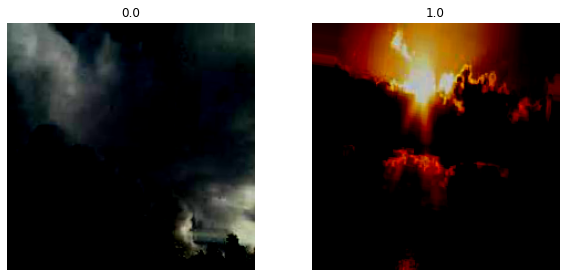

In [21]:
#Print image per type
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
images, labels = train_generator.next()
for i in range(2):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
#0.0 -> cloudy
#1.0 -> sunrise

In [4]:
base_model = InceptionV3(include_top = False, weights="imagenet", input_shape=(224, 224, 3))
#MobileNet architecture with GlobalAveragePooling2D layer and pretrained weights
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())
# model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

In [5]:
#last layers training
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)
 
epochs = 8
 
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=6, mode='auto')
 
model.fit(x=train_generator,
          steps_per_epoch = train_generator.n//train_generator.batch_size,
          validation_data = validation_generator, 
          validation_steps = validation_generator.n//validation_generator.batch_size,
          epochs = epochs)

Epoch 1/8
14/14 [==============================] - 63s 4s/step - loss: 1.4893 - binary_accuracy: 0.5369 - val_loss: 0.8270 - val_binary_accuracy: 0.6354
Epoch 2/8
14/14 [==============================] - 39s 3s/step - loss: 0.4637 - binary_accuracy: 0.8142 - val_loss: 0.4651 - val_binary_accuracy: 0.8333
Epoch 3/8
14/14 [==============================] - 41s 3s/step - loss: 0.2513 - binary_accuracy: 0.8715 - val_loss: 0.2976 - val_binary_accuracy: 0.9062
Epoch 4/8
14/14 [==============================] - 37s 3s/step - loss: 0.2099 - binary_accuracy: 0.9152 - val_loss: 0.2585 - val_binary_accuracy: 0.9271
Epoch 5/8
14/14 [==============================] - 36s 3s/step - loss: 0.1358 - binary_accuracy: 0.9225 - val_loss: 0.1688 - val_binary_accuracy: 0.9479
Epoch 6/8
14/14 [==============================] - 32s 2s/step - loss: 0.0907 - binary_accuracy: 0.9734 - val_loss: 0.1546 - val_binary_accuracy: 0.9375
Epoch 7/8
14/14 [==============================] - 34s 2s/step - loss: 0.0814 - bi

In [6]:
test_scores = model.evaluate(test_generator)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

4/4 [==============================] - 6s 1s/step - loss: 0.0948 - binary_accuracy: 0.9798
Test loss: 0.09476222097873688
Test accuracy: 0.9797979593276978


## Part 3:

References:
- https://stackoverflow.com/a/46359250/9491191
- Prof. James McDermott Notes - Week 7, Slide 52 
- https://stackoverflow.com/a/10695161/9491191
- scipy.stats.pearsonr — SciPy v1.6.3 Reference Guide (2021). Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html (Accessed: 27 April 2021).
- https://stackoverflow.com/a/3308805/9491191

In [13]:
# from tensorflow.keras import backend as K
image_batch, label_batch = next(iter(train_generator))
# layer_name = 'mixed10'

# function = K.function([base_model.get_layer(index=0).input], base_model.get_layer(layer_name).output)
# layer_output = function([image_batch])

layer_name = "mixed10"
layer = base_model.get_layer(name=layer_name)
feature_extractor = keras.Model(base_model.get_layer(index=0).input,layer.output)

layer_output = feature_extractor(image_batch)

In [14]:
neuron_model = keras.layers.GlobalAveragePooling2D()(layer_output)
neuron_model = Softmax()(neuron_model)
neuron_model.numpy()

array([[0.00021148, 0.00034875, 0.00048795, ..., 0.0002292 , 0.00055975,
        0.00018724],
       [0.00052657, 0.00030321, 0.00024414, ..., 0.00080889, 0.00073734,
        0.0002089 ],
       [0.00031035, 0.00028304, 0.00028863, ..., 0.00033381, 0.00047086,
        0.00031242],
       ...,
       [0.00033599, 0.00030169, 0.00032041, ..., 0.00029913, 0.00042269,
        0.00071172],
       [0.0005062 , 0.00033948, 0.00030797, ..., 0.00127865, 0.00044984,
        0.0004082 ],
       [0.00029316, 0.00028204, 0.00029386, ..., 0.00059177, 0.00098287,
        0.00026249]], dtype=float32)

In [15]:
label_batch

array([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [16]:
# zero_indices = np.where(label_batch == 0)
# x = neuron_model.numpy()[zero_indices[0],:]
# y = label_batch[zero_indices[0]]

# import statsmodels.api as sm
# x = np.array(x)
# x = sm.add_constant(x)
# results = sm.OLS(endog=y, exog=x).fit()
# print(results.params)

# print(x.shape)
# print(y.shape)

# one_indices = np.where(label_batch == 1)
# x = neuron_model.numpy()[one_indices[0],:]
# y = label_batch[one_indices[0]]

# import statsmodels.api as sm
# x = np.array(x)
# results = sm.OLS(endog=y, exog=x).fit()
# print(results.params)

In [17]:
from scipy.stats import pearsonr

neurons_cor = []

for index in range(2048):
    correlation, pearson = pearsonr(neuron_model.numpy()[:,index], label_batch)
    neurons_cor.append((index, correlation))
#     if abs(correlation) < 0.5:
#         zero_neurons.append((index, abs(correlation)))
#         zero_neurons.append((index, correlation))
#     else:
#         one_neurons.append((index, abs(correlation)))
#         one_neurons.append((index, correlation))

In [26]:
neurons_cor.sort(key=lambda x: x[1], reverse=True)
# list(list(zip(*neurons_cor))[0])[:5]

0.6935650012582755

In [17]:
# one_neurons.sort(key=lambda x: x[1], reverse=True)
# one_neurons[:5]

# Part 4

References:
- Prof. James McDermott Notes - Week 7, Slide 61
- Team, K. (2021) Keras documentation: Grad-CAM class activation visualization, Keras.io. Available at: https://keras.io/examples/vision/grad_cam/#create-a-superimposed-visualization (Accessed: 28 April 2021).

In [30]:
image, label = train_generator.next()
# layer_output = feature_extractor(np.expand_dims(image[1], axis=0))
layer_output = feature_extractor(image)

neurons = keras.layers.GlobalAveragePooling2D()(layer_output)
neurons = Softmax()(neurons)

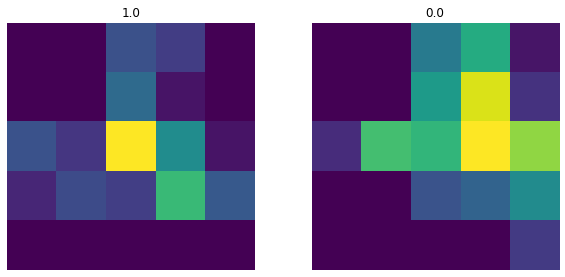

In [45]:
plt.figure(figsize=(10, 10))
for i in range(2):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(layer_output[i,:,:,neurons_cor[0][0]])
    plt.title(label[i])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


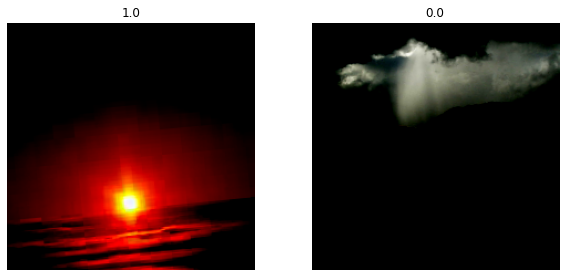

In [32]:
plt.figure(figsize=(10, 10))
for i in range(2):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(image[i])
    plt.title(label[i])
    plt.axis("off")

In [33]:
import matplotlib.cm as cm
from IPython.display import Image, display
import matplotlib.pyplot as plt
def save_and_display_gradcam(img, heatmap, alpha=0.02):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)
 
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # return the superimposed image
    return superimposed_img

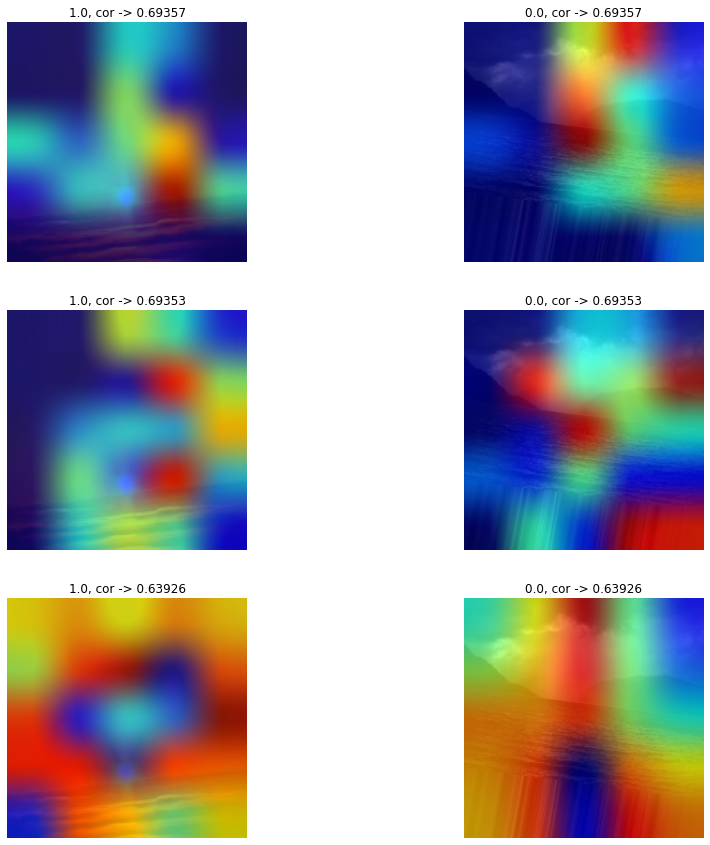

In [57]:
plt.figure(figsize=(15, 15))
place = 0
for j in range(3):
    for i in range(2):
        place +=1
        ax = plt.subplot(3, 2, place)
        plt.imshow(save_and_display_gradcam(image[i], layer_output[i,:,:,neurons_cor[j][0]]))
        plt.title(str(label[i]) + ", cor -> " + str(round(neurons_cor[j][1], 5)))
        plt.axis("off")